   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
First few rows:
  Accident_Index  Vehicle_Reference  Casualty_Reference  Casualty_Class  \
0  2016010000005                  2                   1               1   
1  2016010000006                  1                   1               1   
2  2016010000008                  1                   1               1   
3  2016010000016                  1                   1               2   
4  2016010000018                  2                   1               1   

   Sex_of_Casualty  Age_of_Casualty  Age_Band_of_Casualty  

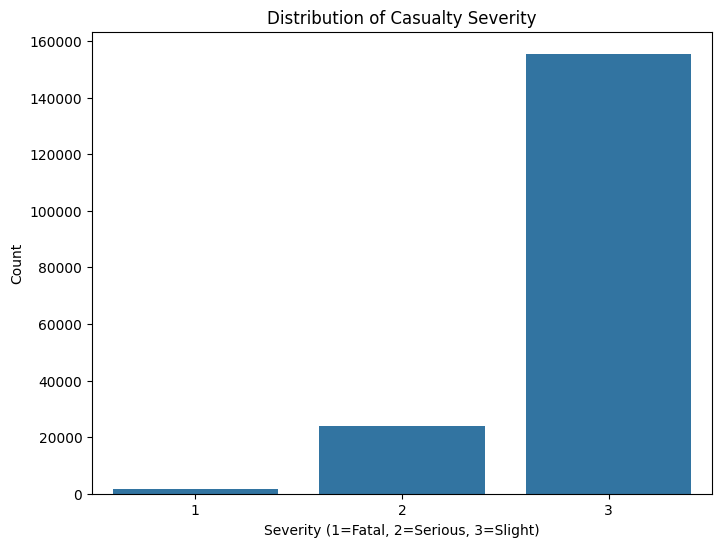

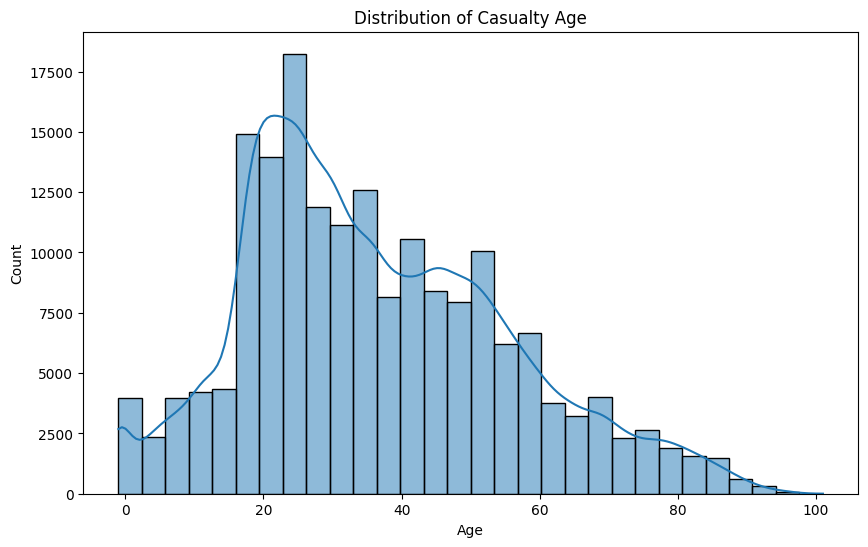


Categorical columns found: ['Accident_Index']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
!pip install gradio
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('road safety.csv')

# Data Exploration
print("First few rows:")
print(df.head())

print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.info())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Visualize Casualty Severity distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Casualty_Severity', data=df)
plt.title('Distribution of Casualty Severity')
plt.xlabel('Severity (1=Fatal, 2=Serious, 3=Slight)')
plt.ylabel('Count')
plt.show()

# Visualize Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age_of_Casualty'], bins=30, kde=True)
plt.title('Distribution of Casualty Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Prepare data for modeling
# Let's predict Casualty Severity based on other features
target = 'Casualty_Severity'
features = df.columns.drop(target)

# Handle categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print("\nCategorical columns found:", categorical_cols.tolist())
    df_encoded = pd.get_dummies(df, drop_first=True)
else:
    df_encoded = df.copy()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(target, axis=1))
y = df_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model building
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\nModel Evaluation:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Prediction function for Gradio
def predict_severity(Accident_Index, Vehicle_Reference, Casualty_Reference, Casualty_Class,
                    Sex_of_Casualty, Age_of_Casualty, Age_Band_of_Casualty,
                    Pedestrian_Location, Pedestrian_Movement, Car_Passenger,
                    Bus_or_Coach_Passenger, Pedestrian_Road_Maintenance_Worker,
                    Casualty_Type, Casualty_Home_Area_Type, Casualty_IMD_Decile):

    input_data = {
        'Accident_Index': Accident_Index,
        'Vehicle_Reference': Vehicle_Reference,
        'Casualty_Reference': Casualty_Reference,
        'Casualty_Class': Casualty_Class,
        'Sex_of_Casualty': Sex_of_Casualty,
        'Age_of_Casualty': Age_of_Casualty,
        'Age_Band_of_Casualty': Age_Band_of_Casualty,
        'Pedestrian_Location': Pedestrian_Location,
        'Pedestrian_Movement': Pedestrian_Movement,
        'Car_Passenger': Car_Passenger,
        'Bus_or_Coach_Passenger': Bus_or_Coach_Passenger,
        'Pedestrian_Road_Maintenance_Worker': Pedestrian_Road_Maintenance_Worker,
        'Casualty_Type': Casualty_Type,
        'Casualty_Home_Area_Type': Casualty_Home_Area_Type,
        'Casualty_IMD_Decile': Casualty_IMD_Decile
    }

    input_df = pd.DataFrame([input_data])

    # Combine with original data to ensure all dummy columns are present
    df_temp = pd.concat([df.drop(target, axis=1), input_df], ignore_index=True)

    # One-hot encode if needed
    if len(categorical_cols) > 0:
        df_temp_encoded = pd.get_dummies(df_temp, drop_first=True)
        # Ensure all columns match training data
        df_temp_encoded = df_temp_encoded.reindex(columns=df_encoded.drop(target, axis=1).columns, fill_value=0)
    else:
        df_temp_encoded = df_temp

    # Scale features
    scaled_input = scaler.transform(df_temp_encoded.tail(1))

    # Predict
    prediction = model.predict(scaled_input)

    # Interpret prediction (1=Fatal, 2=Serious, 3=Slight)
    severity = round(prediction[0])
    severity = max(1, min(3, severity))  # Ensure it's between 1 and 3

    severity_map = {1: "Fatal", 2: "Serious", 3: "Slight"}
    return severity_map.get(severity, "Unknown")

# Create Gradio interface
inputs = [
    gr.Textbox(label="Accident Index"),
    gr.Number(label="Vehicle Reference"),
    gr.Number(label="Casualty Reference"),
    gr.Dropdown([1, 2, 3], label="Casualty Class (1=Driver, 2=Passenger, 3=Pedestrian)"),
    gr.Dropdown([1, 2], label="Sex of Casualty (1=Male, 2=Female)"),
    gr.Number(label="Age of Casualty"),
    gr.Dropdown([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], label="Age Band of Casualty"),
    gr.Number(label="Pedestrian Location (0=Not Pedestrian)"),
    gr.Number(label="Pedestrian Movement (0=Not Pedestrian)"),
    gr.Number(label="Car Passenger (0=No, 1=Front, 2=Rear, 3=Other)"),
    gr.Number(label="Bus or Coach Passenger (0=No, 1=Front, 2=Rear, 3=Other)"),
    gr.Number(label="Pedestrian Road Maintenance Worker (0=No, 1=Yes, 2=Unknown)"),
    gr.Number(label="Casualty Type"),
    gr.Dropdown([1, 2, 3], label="Casualty Home Area Type (1=Urban, 2=Rural, 3=Unallocated)"),
    gr.Dropdown([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], label="Casualty IMD Decile (1=Most Deprived, 10=Least Deprived)")
]

output = gr.Textbox(label="Predicted Casualty Severity")

# Launch the app
gr.Interface(
    fn=predict_severity,
    inputs=inputs,
    outputs=output,
    title="🚦 Road Accident Severity Predictor",
    description="Predict the severity of a road accident casualty based on various factors."
).launch()